In [1]:
num_epochs = 50

In [2]:
# Import the data for each company
import pandas as pd

#Empresa
df = pd.read_csv('GFINBURO.csv')
df

#Define the target
target = "Cierre"

df = df.drop(['Fecha','% var.','Vol.'], axis=1)
df = df.iloc[::-1].reset_index(drop=True)
df

,Cierre,Apertura,Máximo,Mínimo
0,24.62,23.45,24.89,23.45
1,24.56,24.30,24.70,24.15
2,24.83,24.35,24.92,24.33
3,24.22,24.67,24.67,23.90
4,24.11,24.16,24.90,23.90
...,...,...,...,...
1143,43.85,44.21,45.00,43.58
1144,43.64,43.56,44.10,42.82
1145,43.08,43.75,44.67,42.83
1146,43.96,43.65,44.12,43.16


In [3]:
#Define the features
features = list(df.columns.difference([]))
features

['Cierre', 'Apertura', 'Máximo', 'Mínimo']

In [4]:
#Define the training and test percentages
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [5]:
#Normalize the data
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [6]:
#LSTM training
from utils import SequenceDataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

#Sets the seed for generating random numbers
torch.manual_seed(101) 

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [7]:
#Define functions to train/test the model
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [8]:
#Define the parameters to train the model
from utils import ShallowRegressionLSTM
from torch import nn

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,num_epochs):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 4.879539513336322
Test accuracy: 0.20493736689151762

Epoch 0
---------
Train loss: 0.7250834581904815
Train accuracy: 1.3791513939381002
Test loss: 2.428034225444366
Test accuracy: 0.4118557919550768
Epoch 1
---------
Train loss: 0.16136605744389704
Train accuracy: 6.197086277819281
Test loss: 1.0058817836025549
Test accuracy: 0.9941525106491738
Epoch 2
---------
Train loss: 0.033185375957180616
Train accuracy: 30.133664537169963
Test loss: 0.7958584259786389
Test accuracy: 1.2565047271062852
Epoch 3
---------
Train loss: 0.025930988199596904
Train accuracy: 38.56374990138458
Test loss: 0.7540187045267712
Test accuracy: 1.326226871261664
Epoch 4
---------
Train loss: 0.0212935548842544
Train accuracy: 46.96234655044824
Test loss: 0.6971512766684725
Test accuracy: 1.434408700128761
Epoch 5
---------
Train loss: 0.017370400486264023
Train accuracy: 57.568865145294154
Test loss: 0.6212695764503661
Test accuracy: 1.6096069676432876
Epoch 6
---------
Trai

In [9]:
#Save the cmodel
torch.save(model.state_dict(), "./cmodelINBURSA" )

In [10]:
#Define the function to predict using the model
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [11]:
#Compare the real value vs. the predicted value
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Cierre  Model forecast
0      24.62       24.433212
1      24.56       24.600866
2      24.83       24.813837
3      24.22       24.266043
4      24.11       24.250118
...      ...             ...
1143   43.85       43.677090
1144   43.64       43.262917
1145   43.08       43.070740
1146   43.96       43.459091
1147   44.36       43.787354

[1149 rows x 2 columns]


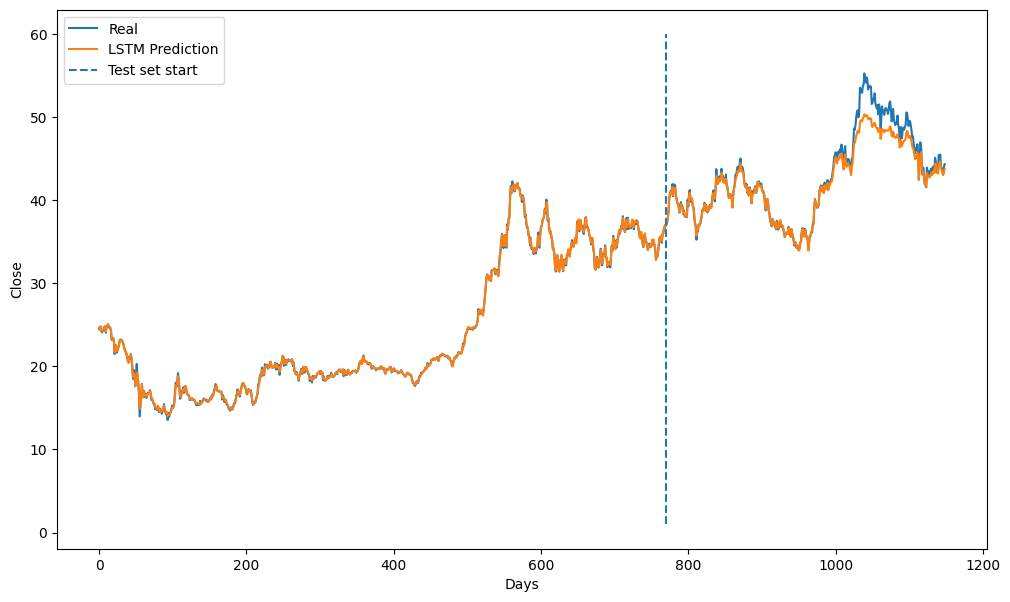

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 60, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

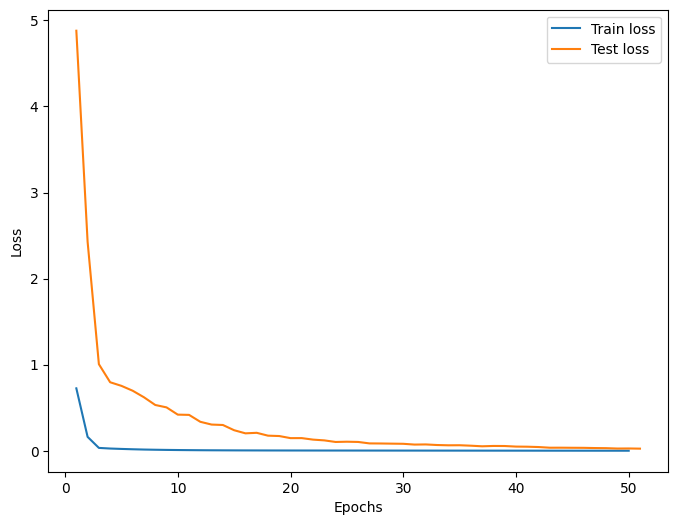

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), classical_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), classical_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [14]:
#Quantum prediction
from utils import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits = 4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [15]:
#Train the quantum model
import time

quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 5.821452542471068
Test accuracy: 0.1717784308171446
Execution time 19.46619939804077
Epoch 0
---------
Train loss: 0.05443930863312903
Train accuracy: 18.36904597437988
Test loss: 0.40875644386313514
Test accuracy: 2.4464440142023323
Execution time 92.50431847572327
Epoch 1
---------
Train loss: 0.004053620408918018
Train accuracy: 246.68696879045754
Test loss: 0.31903117221011706
Test accuracy: 3.134488958002181
Execution time 92.67080068588257
Epoch 2
---------
Train loss: 0.002524248865070027
Train accuracy: 396.1417591035934
Test loss: 0.2577381163773272
Test accuracy: 3.8799057976563556
Execution time 92.72115588188171
Epoch 3
---------
Train loss: 0.001861538238932776
Train accuracy: 537.1612911073805
Test loss: 0.2052195659279652
Test accuracy: 4.872827345655134
Execution time 92.43224382400513
Epoch 4
---------
Train loss: 0.0015184743275112281
Train accuracy: 658.512383545221
Test loss: 0.18298579469701917
Test accuracy: 5.46490209890637
Exec

In [16]:
#Save the qmodel
torch.save(Qmodel.state_dict(), "./qmodelINBURSA" )

In [17]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Cierre  Model forecast
0      24.62       24.447523
1      24.56       24.510044
2      24.83       24.802803
3      24.22       24.151253
4      24.11       24.223751
...      ...             ...
1143   43.85       43.573635
1144   43.64       43.299744
1145   43.08       43.031792
1146   43.96       43.420563
1147   44.36       43.718941

[1149 rows x 2 columns]


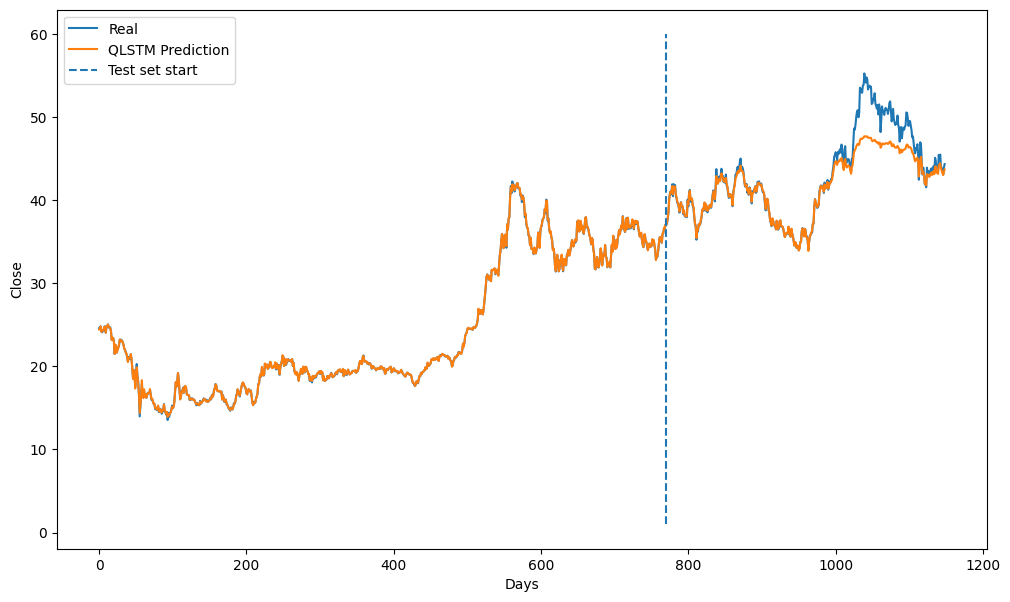

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(0,len(df) + 1), df_out_Q["Cierre"], label = "Real")
plt.plot(range(0,len(df) + 1), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 60, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

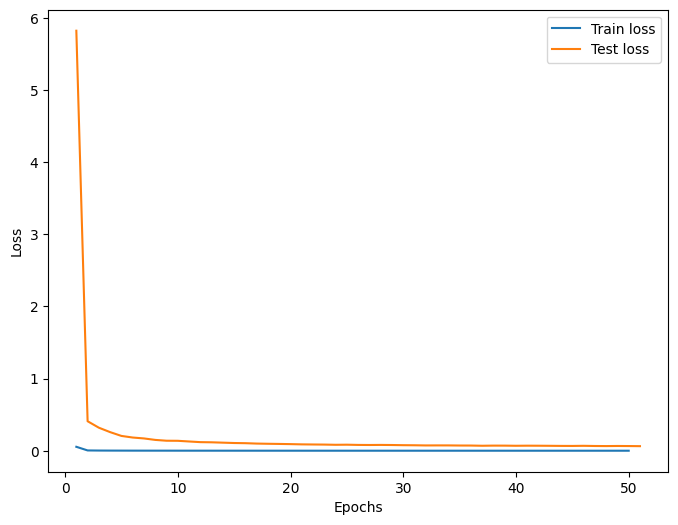

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), quantum_loss_train, label = "Train loss")
plt.plot(range(1, num_epochs + 2), quantum_loss_test, label="Test loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

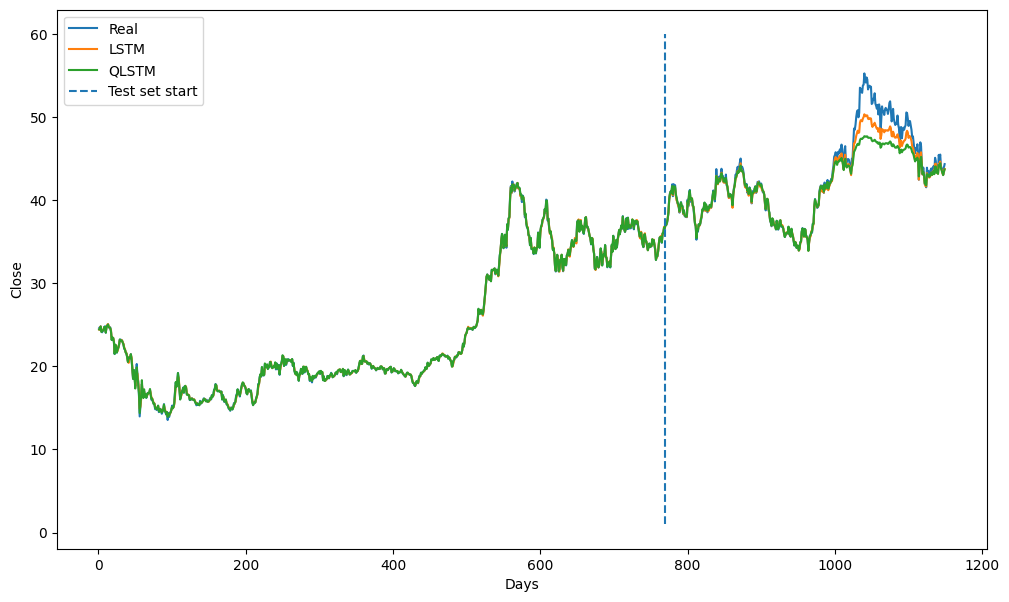

In [20]:
##Comparison between classical and quantum
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(df) + 2), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1, len(df) + 2), df_out["Model forecast"], label = "LSTM")
plt.plot(range(1, len(df) + 2), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Close')
plt.xlabel('Days')
plt.vlines(size, ymin = 1, ymax = 60, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()